### analysis of disease and bias "encoding" within principal components of feature space extracted from intermediate layers of a CNN:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
tf.random.set_seed(1)
import random
random.seed(1)
import seaborn as sns
from sklearn import decomposition
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
# functions to compute accuracy of a logistic regression classifier for predicting disease class or bias subgroup 
# from individual PCs
def bias_acc(column):
    X=column.values.reshape(-1,1)
    y = df['morph_bias_label'].values

    clf = LogisticRegression(random_state=0).fit(X,y)
    acc = accuracy_score(y, clf.predict(X))
    return acc


def disease_acc(column):
    X=column.values.reshape(-1,1)
    y = df['class_label'].values

    clf = LogisticRegression(random_state=0).fit(X,y)
    acc = accuracy_score(y, clf.predict(X))  
    return acc

In [6]:
# renaming convention for layers (e.g., mp3 -> block 3)
layername_dict={'mp3': '3',
                'mp4': '4',
                'mp5': '5', 
                'flatten1': '6'}

# number of PCs to display for each layer 
num_pcs_dict={'mp3': 10,
              'mp4': 8,
              'mp5': 6, 
              'flatten1': 3}

In [8]:
exp_name = 'morph_bias'
working_dir = f'/home/emma/Documents/SBB/{exp_name}/'
pc_dir = working_dir + 'PC_enc_plots/'
Path(pc_dir).mkdir(parents=True, exist_ok=True)

(1074, 5)
overall bias prediction accuracy:0.9962756052141527
overall disease prediction accuracy:0.8603351955307262


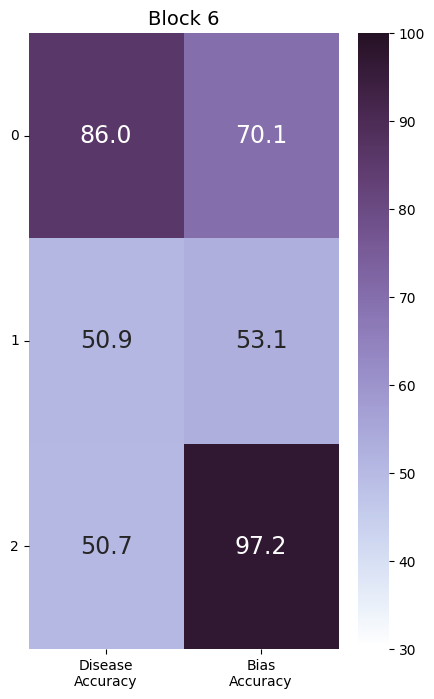

In [18]:
layername = 'flatten1' 

#load features
embeds = np.load(working_dir + 'split/' + exp_name + f'_features_{layername}.npy')

#load dataframe with metadata for test images
fn_test = working_dir + f"preds_{exp_name}.csv"
df = pd.read_csv(fn_test, index_col = 'filepath')

#perform PCA on features
pca = decomposition.PCA(n_components=0.99, whiten=False, random_state=0)
embeds_pca = pca.fit_transform(embeds)
print(embeds_pca.shape)

# aggregate encoding - perform logistic regression classification from full PC space
X = embeds_pca
y = df['morph_bias_label']

clf = LogisticRegression(random_state=0).fit(X,y)
acc = accuracy_score(y, clf.predict(X))
print(f'overall bias prediction accuracy:{acc}')

y = df['class_label']

clf = LogisticRegression(random_state=0).fit(X,y)
acc = accuracy_score(y, clf.predict(X))
print(f'overall disease prediction accuracy:{acc}')

# individual encoding - perform logistic regression classification from each individual PC
df1 = pd.DataFrame.from_records(embeds_pca) #df of entire PCA (columns = components, rows = features)

# Apply the custom calculation to each column (component) in df1
df2 = df1.apply(bias_acc, axis=0) #bias prediction accuracy per PC
df3 = df1.apply(disease_acc, axis=0) #disease prediction accuracy per PC

#dataframe with individual encoding values for each PC
df_pc = pd.concat([df3, df2], axis=1).rename(columns={0: 'Disease\nAccuracy', 1: 'Bias\nAccuracy'})
# print(df_pc.head())

#heatmap plotting 
df_pc = df_pc.head(num_pcs_dict[layername])
df_pc = df_pc.mul(100)

#https://stackoverflow.com/questions/46394974/scale-heatmaps-of-different-dimensions-to-make-cells-equal-in-size
#https://stackoverflow.com/questions/64173951/seaborn-heatmap-in-subplots-with-equal-cell-sizes
plt.figure(figsize = (5,8))
fig = sns.heatmap(data=df_pc, annot=True, fmt='.1f', annot_kws={"fontsize":17}, vmin=30, vmax=100, cmap=sns.cubehelix_palette(start=.5, rot=-.25, dark=0.1, light=1, as_cmap=True))
figure_name=f'PC_heatmap_block_{layername}_morphBias_percent'
plt.title(f'Block {layername_dict[layername]}', fontsize=14)
plt.yticks(rotation=0)
plt.show()
# plt.savefig(pc_dir + figure_name + '.png', dpi=300, bbox_inches='tight')
# plt.savefig(pc_dir + figure_name + '.svg', bbox_inches='tight')
# plt.clf()



overall disease prediction accuracy:0.8603351955307262
[[-1.01539132]] [-0.26842531]


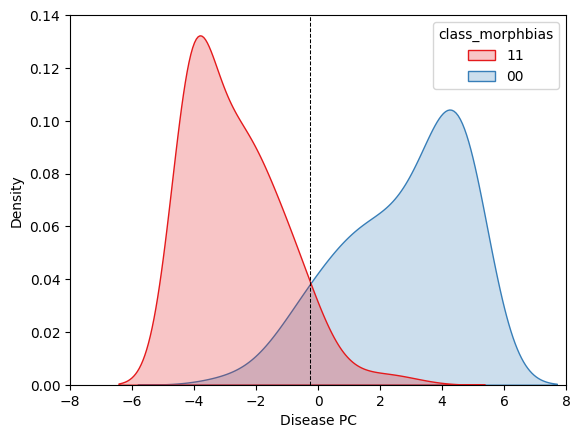

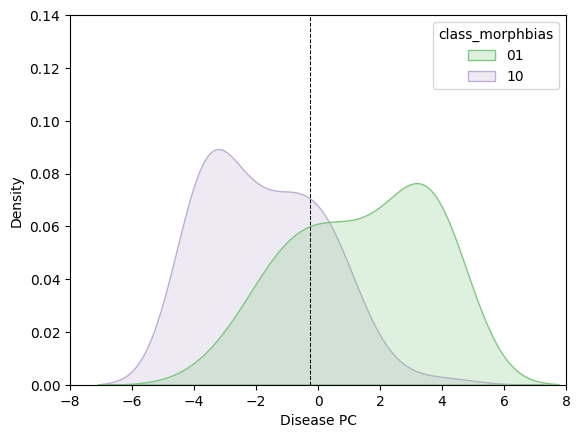

In [19]:
def plot_diseasePCsubgroups_maj(df):
    ''' plot majority bias subgroups ("shortcut groups")'''
    ax = sns.kdeplot(data=df, x='Disease PC', hue='class_morphbias',  bw_adjust=1.5, fill=True, palette='Set1')
    ax.axvline(x=boundary, color='black', linestyle='--', lw=0.75)
    # ax.get_legend().remove()
    ax.set_xlim([-8, 8])
    ax.set_ylim([0, 0.14])

def plot_diseasePCsubgroups_min(df):
    ''' plot minority bias subgroups ("non-shortcut groups")'''
    ax = sns.kdeplot(data=df, x='Disease PC', hue='class_morphbias',  bw_adjust=1.5, fill=True, palette='Accent')
    ax.axvline(x=boundary, color='black', linestyle='--', lw=0.75)
    # ax.get_legend().remove()
    ax.set_xlim([-8, 8])
    ax.set_ylim([0, 0.14])

# get disease-dominant PC 
d_idx = df_pc['Disease\nAccuracy'].idxmax()
df['Disease PC']=df1.iloc[:,d_idx].values

# plot linear decision boundary separating disease classes along the disease-dominant PC
X = df['Disease PC'].values.reshape(-1, 1)
y = df['class_label'].values

clf = LogisticRegression(random_state=0).fit(X,y)
acc = accuracy_score(y, clf.predict(X))
print(f'overall disease prediction accuracy:{acc}')
print(clf.coef_, clf.intercept_)

boundary = (clf.intercept_[0]*-1)/clf.coef_[0][0]
df['class_morphbias'] = df['class_label'].astype(str) + df['morph_bias_label'].astype(str) #make a new column for label of class + bias


#plot majority subgroups only
figname = 'majority_groups'
df_maj = df.loc[(df['class_morphbias'] == '11') | (df['class_morphbias'] == '00')] #00 = ND + NB, 11 = D + B
plot_diseasePCsubgroups_maj(df_maj)
# plt.savefig(pc_dir +  'diseasePCplot_' + figname + '.png', dpi=300, bbox_inches='tight')
# plt.savefig(pc_dir +  'diseasePCplot_' + figname + '.svg', bbox_inches='tight')
# plt.clf()
plt.show()

#plot minority subgroups only
figname = 'minority_groups'
df_min = df.loc[(df['class_morphbias'] == '01') | (df['class_morphbias'] == '10')] #01 = ND + B, 10 = D + NB
plot_diseasePCsubgroups_min(df_min)
# plt.savefig(pc_dir +  'diseasePCplot_' + figname + '.png', dpi=300, bbox_inches='tight')
# plt.savefig(pc_dir +  'diseasePCplot_' + figname + '.svg', bbox_inches='tight')
# plt.clf()
plt.show()